<a href="https://colab.research.google.com/github/tony3ynot/Vision_Transformer/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Model Architecture**

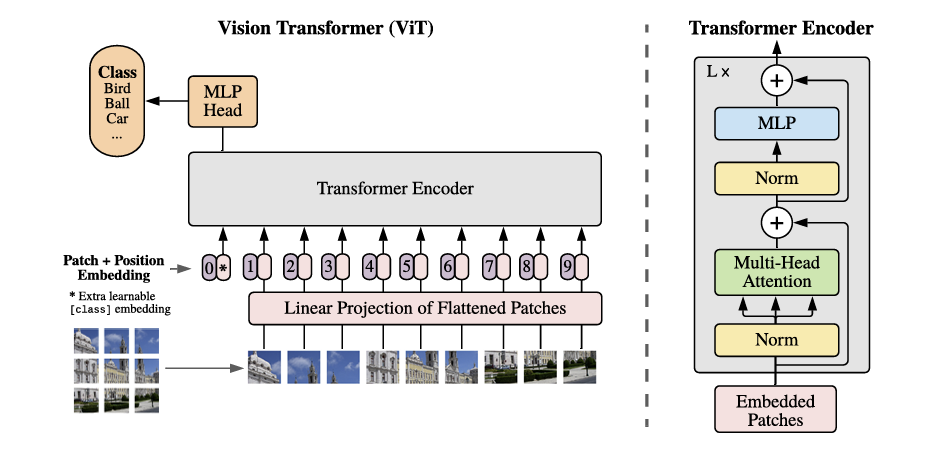

In [3]:
## Embedding
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        super().__init__()
        self.patch_size = patch_size

        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size), #torch.Size([b, 768, 14, 14])
            Rearrange('b e (h) (w) -> b (h w) e') #torch.Size([b, 196, 768])
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size)) #[1, 1, 768] CLS Token : trainable
        self.positions = nn.Parameter(torch.randn((img_size // patch_size)**2 + 1, emb_size)) #[197, 768] Position Embedding : trainable

    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b) #[1, 1, 768] -> [b, 1, 768]
        x = torch.cat([cls_tokens, x], dim = 1)
        x += self.positions

        return x

In [4]:
## Transformer Encoder

# Multi-Head Attention
class MHA(nn.Module):
    def __init__(self, emb_size=768, num_heads=8, drop_p=0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads

        self.fc_q = nn.Linear(emb_size, emb_size)
        self.fc_k = nn.Linear(emb_size, emb_size)
        self.fc_v = nn.Linear(emb_size, emb_size)

        self.scale = torch.sqrt(torch.tensor(emb_size))

        self.dropout = nn.Dropout(drop_p)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x, mask = None):
        Q = self.fc_q(x)
        K = self.fc_k(x)
        V = self.fc_v(x)

        Q = rearrange(Q, 'b n (h d) -> b h n d', h = self.num_heads)
        K = rearrange(K, 'b n (h d) -> b h n d', h = self.num_heads)
        V = rearrange(V, 'b n (h d) -> b h n d', h = self.num_heads)

        energy = Q @ K.transpose(-2, -1)/self.scale
        if mask is not None:
            energy[mask] = -1e10

        attention = F.softmax(energy, dim=-1)
        attention = self.dropout(attention)
        x = attention @ V
        x = rearrange(x, 'b h n d -> b n (h d)')
        x = self.projection(x)

        return x

# FFN
class FeedForward(nn.Module):
    def __init__(self, emb_size=768, expansion=4, drop_p=0):
        super().__init__()
        self.linear = nn.Sequential(nn.Linear(emb_size, expansion * emb_size),
                                    nn.GELU(), #GELU instead of ReLU
                                    nn.Dropout(drop_p),
                                    nn.Linear(expansion * emb_size, emb_size))

    def forward(self, x):
        x = self.linear(x)
        return x

# Encoder Block
class EncoderBlock(nn.Module):
    def __init__(self, emb_size=768, num_heads=8, expansion=4, drop_p=0, MHAdrop_p=0, fdrop_p=0):
        super().__init__()

        self.self_atten_LN = nn.LayerNorm(emb_size)
        self.self_atten = MHA(emb_size, num_heads, MHAdrop_p)
        self.self_atten_dropout = nn.Dropout(drop_p)

        self.FF_LN = nn.LayerNorm(emb_size)
        self.FF = FeedForward(emb_size, expansion, fdrop_p)
        self.FF_dropout = nn.Dropout(drop_p)

    def forward(self, x):
        residual = self.self_atten_LN(x)
        residual = self.self_atten(residual)
        residual = self.self_atten_dropout(residual)
        x = residual + x

        residual = self.FF_LN(x)
        residual = self.FF(residual)
        residual = self.FF_dropout(residual)
        x = residual + x

        return x

# Encoder
class Encoder(nn.Sequential):
    def __init__(self, depth=12, **kwargs):
        super().__init__(*[EncoderBlock(**kwargs) for _ in range(depth)])

In [5]:
## ViT
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=758, n_classes=1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes))

class ViT(nn.Sequential):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224, depth=12, n_classes=1000, **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            Encoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [6]:
x = torch.randn(8, 3, 224, 224)

summary(ViT(), x.shape[1:], device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5             [-1, 197, 768]         590,592
            Linear-6             [-1, 197, 768]         590,592
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8          [-1, 8, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
              MHA-10             [-1, 197, 768]               0
          Dropout-11             [-1, 197, 768]               0
        LayerNorm-12             [-1, 197, 768]           1,536
           Linear-13            [-1, 197, 3072]       2,362,368
             GELU-14            [-1, 19